In [1]:
import synthetic_data
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random

In [2]:
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

##### train and test data:

context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()

##### deployment data:

context_generator.set_b(0.15)
X_depl, y_depl, dist_depl = None, None, []
X_depl2, y_depl2, dist_depl2 = None, None, []

for _ in range(5000):
    norm_context, distribution = context_generator.get_context(True)
    dist_depl.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 
    X_depl = norm_context if X_depl is None else np.concatenate((X_depl, norm_context), axis=0)
    y_depl = [[outcome]] if y_depl is None else np.concatenate( (y_depl, [[outcome]]), axis=0)

for _ in range(10000):
    norm_context, distribution = context_generator.get_context(True)
    dist_depl2.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 
    X_depl2 = norm_context if X_depl2 is None else np.concatenate((X_depl2, norm_context), axis=0)
    y_depl2 = [[outcome]] if y_depl2 is None else np.concatenate( (y_depl2, [[outcome]]), axis=0)

print( X_depl.shape , y_depl.shape )
print( X_depl2.shape , y_depl2.shape )

(5000, 2) (5000, 1)
(10000, 2) (10000, 1)


In [3]:
class Evaluate:

    def __init__(self, ):
        pass

    def get_feedback(self, game, action, outcome ):
        return game.FeedbackMatrix[ action ][ outcome ]
        
    def train(self,game,alg,X, y, dist):

        history = [] 
        cumRegret =  np.zeros(len(y), dtype =float)
        t = 0
        global_loss = []
        global_losses = []
        
        for context, outcome, distribution in zip(X, y, dist):

            context = context.reshape((1,-1))
            outcome = outcome[0]

            action, data = alg.get_action(t, context)

            data.append(context)
            history.append( data )

            print('t', t, 'action', action, 'outcome', outcome, 'counter', alg.counter )
            feedback =  self.get_feedback( game, action, outcome )
            if alg.over_budget == False:
                loss, losses = alg.update(action, feedback, outcome, t, context )
            else:
                break

            global_loss.append(loss)
            global_losses.append(losses)

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret[t] =  val
            t+=1

        return history, cumRegret, global_loss, global_losses

    def commit(self,game, alg, X , y, dist):

        history = [] 
        cumRegret =  np.zeros(len(y), dtype =float)
        t = 0
        for context, outcome, distribution in zip(X, y, dist):

            context = context.reshape((1,-1))

            outcome = outcome[0]

            action, data = alg.get_action(t, context, 'eval')

            history.append( data )
            print('t', t, 'action', action, 'outcome', outcome, )

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret[t] =  val
            t+=1

        return history, cumRegret

In [8]:
import numpy as np
import random
import torch
import cbpside
import rand_cbpside
import synthetic_data
import neural_lin_cbpside_disjoint
import rand_neural_lin_cbpside_disjoint
import games
import explore_commit

np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()
context_generator.set_b(0.15)

budget = 2000

game = games.label_efficient( )

lbd_neural = 0
lbd_reg = 1

sigma = 1/8
K = 10
epsilon = 10e-7
alg = rand_neural_lin_cbpside_disjoint.CBPside( game,  budget, 1.01, lbd_neural, lbd_reg, sigma, K, epsilon, 20, 'cuda:0')

# alg = explore_commit.ExploreCommit( game, budget, 2, 0, 20, 'cuda:0')

alg.reset(context_generator.d)
path = './models/quintic.pth'
alg.load(path)

evaluator = Evaluate()

In [9]:
history, cumRegret, global_loss, global_losses = evaluator.train(game, alg, X_depl, y_depl, dist_depl)

t 0 action 0 outcome 0 counter 0
t 1 action 1 outcome 0 counter 1
t 2 action 2 outcome 1 counter 1
factor 4.079274748468425 width [[6.38599461]]
factor 3.190385859579536 width [[6.04803036]]
factor 2.392789394684652 width [[23.79952217]]
pair [1, 2] tdelta [1.25552927] confidence [[26.05022657]]
0 40.78092720561475 0.46436971462593685
1 36.578671294297436 inf
2 566.4172555504315 inf
union1 [1 2] R [0]
t 3 action 0 outcome 0 counter 1
factor 5.085572412145266 width [[3.49171482]]
factor 2.782122910723908 width [[4.75288268]]
factor 1.5897845204136618 width [[17.03225881]]
pair [1, 2] tdelta [0.88004011] confidence [[17.75736855]]
0 12.192072373240695 0.35473256751132826
1 22.589893804276745 inf
2 290.09784016904996 inf
union1 [1 2] R [0]
t 4 action 0 outcome 0 counter 2
factor 2.0309301320620716 width [[8.14250022]]
factor 1.5864856876176274 width [[23.91912382]]
factor 0.0 width [[4.99030616]]
pair [1, 2] tdelta [0.77835557] confidence [[16.53684904]]
0 66.30030977270832 0.290862766154

In [13]:
alg.over_budget = False
history_val, cumRegret_val = evaluator.commit(game, alg, X_depl2, y_depl2, dist_depl2)

t 0 action 0 outcome 0
t 1 action 1 outcome 1
t 2 action 2 outcome 0
factor 1.0198186871171062 width [[0.13563811]]
factor 0.797596464894884 width [[0.35927173]]
factor 2.392789394684652 width [[0.29299246]]
pair [1, 2] tdelta [-0.22528738] confidence [[0.13832628]]
union1 [1] R []
t 3 action 1 outcome 1
factor 5.085572412145266 width [[0.17084308]]
factor 0.0 width [[0.48101636]]
factor 0.39744613010341545 width [[0.32437119]]
pair [1, 2] tdelta [-0.00101218] confidence [[0.86883486]]
union1 [1] R []
t 4 action 1 outcome 1
factor 0.0 width [[0.15490668]]
factor 1.1898642657132206 width [[0.3760514]]
factor 1.5864856876176274 width [[0.35073902]]
pair [1, 2] tdelta [0.45378023] confidence [[0.]]
union1 [2] R []
t 5 action 2 outcome 0
factor 4.057415826471358 width [[0.15440342]]
factor 1.5842634687912343 width [[0.37553021]]
factor 1.1881976015934257 width [[0.34992188]]
pair [1, 2] tdelta [0.44892814] confidence [[0.62647889]]
union1 [2] R []
t 6 action 2 outcome 0
factor 3.0406637396

union1 [2] R []
t 106 action 2 outcome 0
factor 6.053885694024373 width [[0.15349158]]
factor 3.14703490712736 width [[0.37425247]]
factor 1.57351745356368 width [[0.34755132]]
pair [1, 2] tdelta [0.44328198] confidence [[0.92922047]]
union1 [2] R []
t 107 action 2 outcome 0
factor 0.0 width [[0.13524677]]
factor 2.753644988298137 width [[0.36760562]]
factor 3.1470228437692995 width [[0.29091962]]
pair [1, 2] tdelta [-0.17497475] confidence [[0.]]
union1 [1] R []
t 108 action 1 outcome 1
factor 1.0089749725952994 width [[0.13427414]]
factor 2.75363462630577 width [[0.35756496]]
factor 1.1801291255596156 width [[0.28940121]]
pair [1, 2] tdelta [-0.21878946] confidence [[0.13547925]]
union1 [1] R []
t 109 action 1 outcome 1
factor 1.0089720657907353 width [[0.15508368]]
factor 1.1801247653527693 width [[0.37640388]]
factor 2.753624452489795 width [[0.35049496]]
pair [1, 2] tdelta [0.45599729] confidence [[0.1564751]]
union1 [2] R []
t 110 action 2 outcome 0
factor 5.044846056497315 width

IndexError: index 5003 is out of bounds for axis 0 with size 5000

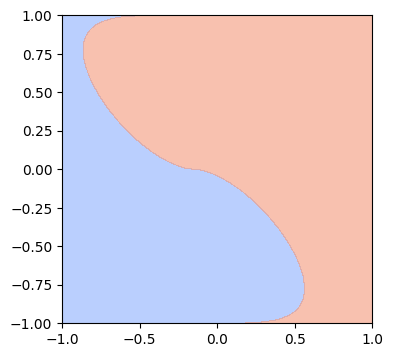

In [14]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
b = 0.15

plt.figure(figsize=(4, 4))

decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)
plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

contexts = np.array( [ context_generator.denormalize(i) for i in X_depl ] ).squeeze(1) 

action0 = [ i[0] if i[0]==2 else np.nan for i in history ]
indices_action0 = np.where(~np.isnan(action0))[0]
contexts0 = contexts[indices_action0]

action1 = [ i[0] if i[0]==1 else np.nan for i in history ]
indices_action1 = np.where(~np.isnan(action1))[0]
contexts1 = contexts[indices_action1]

action2 = [ i[0] if i[0]==0 else np.nan for i in history ]
indices_action2 = np.where(~np.isnan(action2))[0]
contexts2 = contexts[indices_action2]

plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange', label = 'predicted as class 1')
plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue', label = 'predicted as class 2')
plt.plot(contexts2[:,0], contexts2[:,1], '.', color = 'green', label = 'explored')


plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.ylim((-1,1))
plt.xlim((-1,1))
# plt.title('Training decision boundary (shift = {})'.format(b))
plt.title('Deployment decision boundary (shift = {})'.format(b))
plt.legend(loc = (-0.4,-0.25),ncol = 3)
# Save the figure to a file with tight layout and 380 DPI
# plt.savefig('./figures/CBP_DB_{}.png'.format(b), dpi=380, bbox_inches='tight')

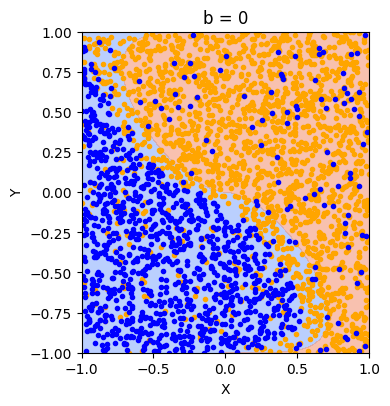

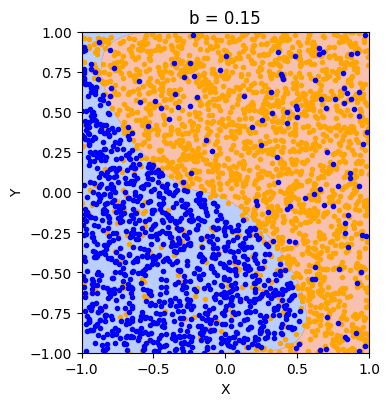

In [16]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
for b in [0, 0.15]:

    plt.figure(figsize=(4, 4))

    decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)

    plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

    contexts = np.array( [ context_generator.denormalize(i) for i in X_depl ] ).squeeze(1) 

    action0 = [ i[0] if i[0]==2 else np.nan for i in history ]
    indices_action0 = np.where(~np.isnan(action0))[0]
    contexts0 = contexts[indices_action0]
    action1 = [ i[0] if i[0]==1 else np.nan for i in history ]
    indices_action1 = np.where(~np.isnan(action1))[0]
    contexts1 = contexts[indices_action1]

    plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange')
    plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue')

    # plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
    # plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')

    # Add labels and title to the plot
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title(' Decision Boundary')
    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.ylim((-1,1))
    plt.xlim((-1,1))
    plt.title('b = {}'.format(b))

    # Save the figure to a file with tight layout and 380 DPI
    # plt.savefig('./figures/decision_boundary_{}.png'.format(idx), dpi=380, bbox_inches='tight')

(0.0, 5000.0)

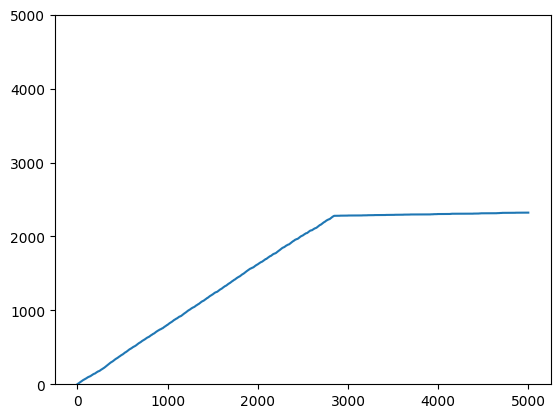

In [17]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(cumRegret))
plt.ylim((0,5000))
# plt.savefig('./figures/CBP_regret_training.png', dpi=380, bbox_inches='tight')

In [18]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.hstack( [ i for i in global_loss if len(i)>0 ] )

plt.figure(figsize=(8, 4))
# plt.ylim( (0, 10) )
plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, len(new_global_loss)) )


def generate_custom_ticks(start, horizon, end, increment, label_increment):
    custom_ticks = list(range(start, end+1 , increment))
    custom_tick_labels = [ str(i) for i in range(start, horizon , label_increment)]
    return custom_ticks, custom_tick_labels

# Define the parameters
start_value = 0
end_value = len(new_global_loss) 
tick_increment = 1000
label_increment = 50
horizon = 1000

custom_ticks, custom_tick_labels = generate_custom_ticks(start_value, horizon, end_value, tick_increment, label_increment)

plt.xticks(custom_ticks, custom_tick_labels, rotation=45, fontsize=7)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss )
plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')

# plt.savefig('./figures/loss_evolution.png', dpi=380, bbox_inches='tight')


TypeError: object of type 'NoneType' has no len()

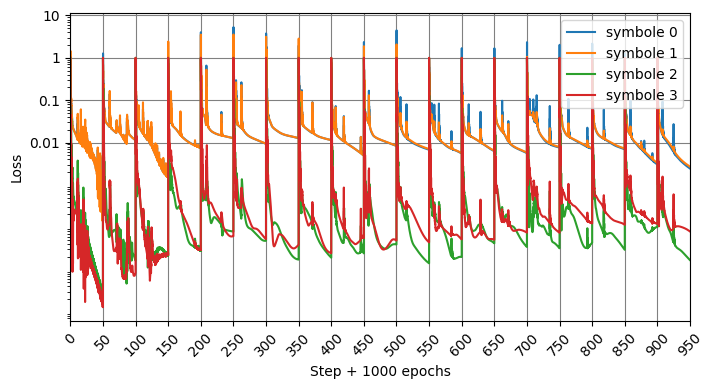

In [29]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.vstack( [ i for i in global_losses if len(i)>0 ] )

plt.figure(figsize=(8, 4))

plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, 19000) )

plt.xticks(custom_ticks, custom_tick_labels, rotation=45)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss[:,0], label = 'symbole 0' )
plt.plot( new_global_loss[:,1], label = 'symbole 1' )
plt.plot( new_global_loss[:,2], label = 'symbole 2' )
plt.plot( new_global_loss[:,3], label = 'symbole 3' )

plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')
plt.legend()

# plt.savefig('./figures/loss_evolution_{}.png'.format(idx), dpi=380, bbox_inches='tight')


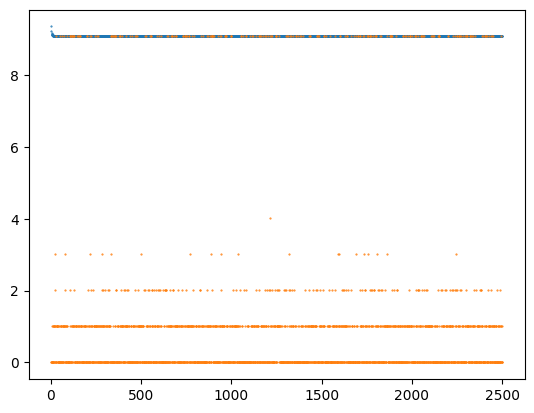

In [66]:


def obtain_probability(t , factor):

    sigma = 1
    K = 10
    epsilon = 0.1#10e-7

    def divide_interval(start, end, k):
        intervals = np.linspace(start, end, k).tolist()
        return intervals

    # U = np.sqrt( self.alpha  * np.log(t) ) 

    U =  factor
    rhos = divide_interval(0, U, K)
    p_m_hat =  np.array([ np.exp( -(rhos[i]**2) / 2*(sigma**2)  )  for i in range(len(rhos)-1) ] )
    p_m = (1 - epsilon) * p_m_hat / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
        
    Z = np.random.choice(rhos, p= p_m)
    return Z

deterministic = []
rand = []

for t in range(1, 2500):
    sigma_i = 2
    d = 2
    N = 3
    H = 50
    lbd_reg = 1
    factor = sigma_i * (  np.sqrt( 2 * ( d  * np.log( 1 + t * np.log(N * H)/lbd_reg ) +  np.log(1/t**2) ) ) + np.sqrt(lbd_reg) * sigma_i )
    rand_value = obtain_probability(t , factor)
    deterministic.append(factor)
    rand.append(rand_value)


plt.plot(range(1,2500), deterministic, '.', markersize = 1)

plt.plot(range(1,2500), rand, '.', markersize = 1)


(array([1.362e+03, 7.500e+02, 1.380e+02, 1.900e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.290e+02]),
 array([0.        , 0.90886871, 1.81773743, 2.72660614, 3.63547486,
        4.54434357, 5.45321229, 6.362081  , 7.27094972, 8.17981843,
        9.08868714]),
 <BarContainer object of 10 artists>)

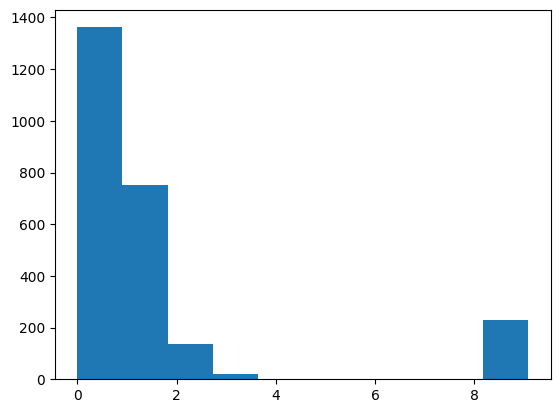

In [67]:
plt.hist(rand, bins = 10)

In [1]:
context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()

V_it_inv = np.identity(20)

vals = []
rates = []

T = 10000

for t in range(1,T):

    norm_context, distribution = context_generator.get_context(True)
    dist_test.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 

    latent_X = alg.func( torch.from_numpy( norm_context ).float().to(alg.device) ).cpu().detach().numpy()

    V_it_inv = V_it_inv - ( V_it_inv @ latent_X.T @ latent_X @ V_it_inv ) / ( 1 + latent_X @ V_it_inv @ latent_X.T ) 

    val =  latent_X @ V_it_inv @ latent_X.T  
    rate = t**(2/3)  * ( 1.01 * np.log(t) )**(1/3)

    vals.append(val[0][0])
    rates.append(1/rate)

plt.plot(range(1,T), vals, '.' , markersize = 0.01, color = 'blue', label = 'pseudo-count')
plt.plot(range(1,T), rates, '.', markersize = 0.01, color = 'red', label = 'exploration threshold')
plt.yscale('log')
plt.legend()

NameError: name 'synthetic_data' is not defined